In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model

In [2]:
BATCH_SIZE = 32
EPOCHS = 20
learning_rate = 1e-4
IMG_SIZE = (224, 224)

In [3]:
data = np.load('./processed-data/data.npy')
labels = np.load('./processed-data/labels.npy')

In [4]:
(train_data, test_data, train_label, test_label) = train_test_split(data, labels, test_size=0.2, random_state=42)

(train_data, validation_data, train_label, validation_label) = train_test_split(train_data, train_label, test_size=0.2, random_state=42)

In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [6]:
IMG_SHAPE = IMG_SIZE + (3, )

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)

base_model.trainable = False

In [7]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [8]:
model = Model(inputs=base_model.input, outputs=head_model)

In [9]:
model.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate / EPOCHS), loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
fitted_model = model.fit(
                        aug.flow(train_data, train_label, batch_size=BATCH_SIZE),
                        steps_per_epoch=len(train_data) // BATCH_SIZE,
                        validation_data=(validation_data, validation_label),
                        epochs=EPOCHS)

Epoch 1/20
131/131 [==============================] - 74s 563ms/step - loss: 0.3587 - accuracy: 0.8461 - val_loss: 0.1598 - val_accuracy: 0.9335
Epoch 2/20
131/131 [==============================] - 74s 567ms/step - loss: 0.1756 - accuracy: 0.9355 - val_loss: 0.1233 - val_accuracy: 0.9515
Epoch 3/20
131/131 [==============================] - 82s 628ms/step - loss: 0.1358 - accuracy: 0.9501 - val_loss: 0.1087 - val_accuracy: 0.9582
Epoch 4/20
131/131 [==============================] - 81s 617ms/step - loss: 0.1153 - accuracy: 0.9576 - val_loss: 0.1002 - val_accuracy: 0.9591
Epoch 5/20
131/131 [==============================] - 81s 621ms/step - loss: 0.0988 - accuracy: 0.9645 - val_loss: 0.0949 - val_accuracy: 0.9686
Epoch 6/20
131/131 [==============================] - 82s 625ms/step - loss: 0.1050 - accuracy: 0.9645 - val_loss: 0.0913 - val_accuracy: 0.9658
Epoch 7/20
131/131 [==============================] - 83s 637ms/step - loss: 0.0880 - accuracy: 0.9672 - val_loss: 0.0864 - val_ac

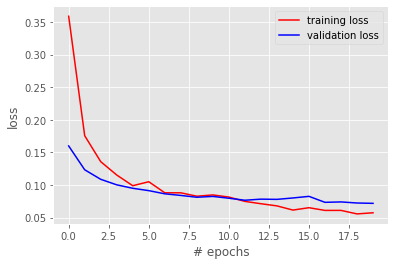

In [40]:
plt.plot(fitted_model.history['loss'], 'r', label='training loss')
plt.plot(fitted_model.history['val_loss'], 'b', label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("plots/loss-plot.png")
plt.show()

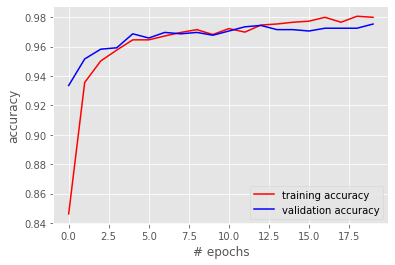

In [41]:
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], 'b', label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("plots/accuracy-plot.png")
plt.show()

In [44]:
print(model.evaluate(test_data, test_label))

42/42 [==============================] - 15s 367ms/step - loss: 0.0673 - accuracy: 0.9718
[0.06731460243463516, 0.9718416929244995]


In [46]:
model.save('face-mask-detector.h5')